In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][2] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=5,speed_key='v')
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [4]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


# all ways for quantifying variability
## relative to one trial
difference
## elapsed trial
aggregated
## aggregated across trials

## population
population vector correlation, at each location, aggregated

- rate 
    - for rate: structure vs unstructured variability
- location
- width
- ratemap similarity

Work on each trialtype independently is fine. Each function, take in a pf_res parameter: fields x trials, 

In [5]:
task_ind,tt_ind = 0,0
pf_param = pf_res['avg']['params'][task_ind,tt_ind]

changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) !=0)].index

In [7]:
def pairwise_trial_difference(df):
    diff_d = {}
    for kk,row in df.iterrows():
        diff = pd.DataFrame(row.values[:,None] - row.values[None,:])
        diff_d[kk] = diff
    diff_d = pd.concat(diff_d,axis=0)

    return diff_d

def agg_similarity_by_elapsed_trial(mat):
    '''
    mat: df, trial x trial
    assume the columns are consecutive
    '''
    mat = mat.values
    ntrials = mat.shape[0]
    mat_agg = np.zeros_like((mat))
    mat_agg[:] = np.nan
    for t in range(ntrials):
        mat_agg[:ntrials - t,t] = np.diag(mat,t)
    mat_agg = pd.DataFrame(mat_agg,columns=range(ntrials))
    mat_agg = mat_agg.loc[:,1:] # get rid of 0 column
    return mat_agg

In [8]:
trialpair_diff_all_params = pf_param.groupby(level=0).apply(pairwise_trial_difference).droplevel(0)
trialpair_diff_all_params_abs = trialpair_diff_all_params.abs()
trialpair_diff_all_params_abs_z = trialpair_diff_all_params_abs.groupby(level=(0,1,2)).apply(scipy.stats.zscore,nan_policy='omit')


In [9]:
trialpair_diff_all_params_by_elapsed = trialpair_diff_all_params.groupby(level=(0,1,2)).apply(agg_similarity_by_elapsed_trial)

trialpair_diff_all_params_by_elapsed_abs = trialpair_diff_all_params_by_elapsed.abs()

trialpair_diff_all_params_by_elapsed_abs_z = trialpair_diff_all_params_by_elapsed_abs.groupby(level=(0,1,2)).apply(scipy.stats.zscore,nan_policy='omit')


In [10]:
par_key_l = trialpair_diff_all_params_by_elapsed.index.get_level_values(0).unique()

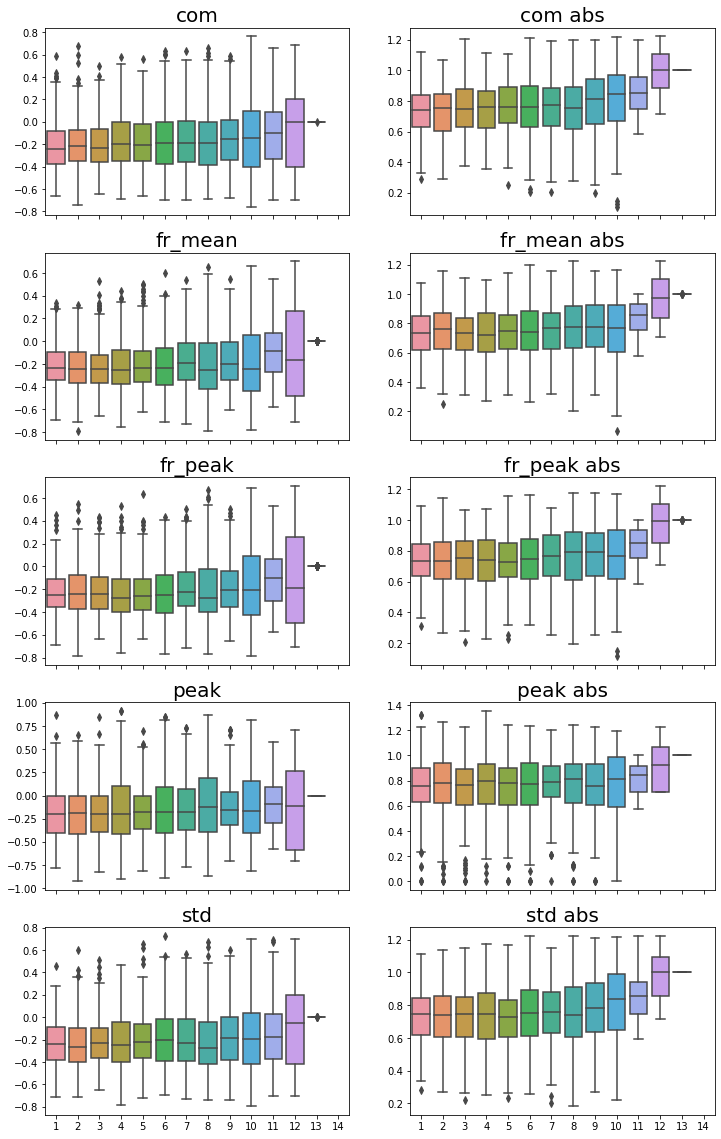

In [161]:
toplot_data = trialpair_diff_all_params_by_elapsed_abs_z#trialpair_diff_all_params_by_elapsed
par_key_l = toplot_data.index.get_level_values(0).unique()

nplots = len(par_key_l)
fig,axs=plt.subplots(nplots,2,sharex=True,figsize=(2*6,nplots*4))
for n,par_key in enumerate(par_key_l):
    toplot = toplot_data.loc[par_key].groupby(level=(0,1)).median()
    sns.boxplot(data=toplot,ax=axs[n,0])
    axs[n,0].set_title(f'{par_key}')

    toplot = toplot_data.loc[par_key].abs().groupby(level=(0,1)).median()
    sns.boxplot(data=toplot,ax=axs[n,1])
    axs[n,1].set_title(f'{par_key} abs')

In [11]:
def melt_elapsed_trial_diff_mat_sep_fields(mat,fields_ind_d,mat_key='value'):
    '''
    seperate fields from one elapsed_trial to diff df, melt, concatenate
    '''
    mat_melt_combined = {}
    mat_med = mat.groupby(level=(0,1)).median()
    for k,val in fields_ind_d.items():
        
        mat_melt_combined[k]=mat_med.loc[val].melt()
    mat_melt_combined = pd.concat(mat_melt_combined,axis=0)
    mat_melt_combined=mat_melt_combined.reset_index(level=0)
    mat_melt_combined = mat_melt_combined.rename({'level_0':'switch_type','variable':'trial','value':mat_key},axis=1)
    return mat_melt_combined

def melt_elapsed_trial_diff_mat_sep_fields_all_params(trialpair_diff_all_params_by_elapsed,fields_ind_d,mat_key_l=None):
    if mat_key_l is None:
        mat_key_l = trialpair_diff_all_params_by_elapsed.index.get_level_values(0).unique()
    mat_melt_combined_all = []
    for mat_key in mat_key_l:
        mat = trialpair_diff_all_params_by_elapsed.loc[mat_key]
        mat_melt_combined = melt_elapsed_trial_diff_mat_sep_fields(mat,fields_ind_d,mat_key=mat_key)
        mat_melt_combined_all.append(mat_melt_combined)
    mat_melt_combined_all = pd.concat(mat_melt_combined_all,axis=1)
    mat_melt_combined_all = mat_melt_combined_all.loc[:,~mat_melt_combined_all.columns.duplicated()].copy()
    
    return mat_melt_combined_all



In [12]:
fields_ind_d = {'switch':with_sw_fields,'no_switch':no_sw_fields}
mat_melt_combined_all_abs = melt_elapsed_trial_diff_mat_sep_fields_all_params(trialpair_diff_all_params_by_elapsed_abs,fields_ind_d,mat_key_l=None)

mat_melt_combined_all = melt_elapsed_trial_diff_mat_sep_fields_all_params(trialpair_diff_all_params_by_elapsed,fields_ind_d,mat_key_l=None)





In [13]:
import statsmodels
import statsmodels.formula.api as smf

In [116]:
# non abs
for mat_key in par_key_l:
    model = smf.ols(f'{mat_key}~trial*C(switch_type)',data=mat_melt_combined_all)
    res=model.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    com   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     25.86
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           1.28e-16
Time:                        14:38:30   Log-Likelihood:                -10376.
No. Observations:                6304   AIC:                         2.076e+04
Df Residuals:                    6300   BIC:                         2.079e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [120]:
# abs
for mat_key in par_key_l:
    model = smf.ols(f'{mat_key}~trial*C(switch_type)',data=mat_melt_combined_all_abs)
    res=model.fit()
    print(mat_key)
    display_regression(res)
#     print(res.summary())

com
                                params      p       r2
Intercept                        0.843  0.000  0.05483
C(switch_type)[T.switch]        -0.056  0.338  0.05483
trial                            0.034  0.000  0.05483
trial:C(switch_type)[T.switch]   0.018  0.000  0.05483
fr_mean
                                params      p       r2
Intercept                        1.980  0.000  0.07717
C(switch_type)[T.switch]        -0.387  0.003  0.07717
trial                            0.038  0.000  0.07717
trial:C(switch_type)[T.switch]   0.101  0.000  0.07717
fr_peak
                                params      p       r2
Intercept                        3.177  0.000  0.06886
C(switch_type)[T.switch]        -0.791  0.000  0.06886
trial                            0.041  0.003  0.06886
trial:C(switch_type)[T.switch]   0.164  0.000  0.06886
peak
                                params      p       r2
Intercept                        2.187  0.000  0.04131
C(switch_type)[T.switch]        -0.301  

# alignment from switching on

In [14]:
no_sw_ind_to_query = [(*ind,0) for ind in no_sw_fields]
def realign_to_event(changes_df,trialpair_diff,onoff=1,k=0):
    with_sw_on = changes_df.loc[(changes_df==onoff).sum(axis=1) > 0].index

    row,col = np.nonzero(changes_df.loc[(changes_df==1).sum(axis=1) > 0].values)

    sw_on_field_ind = with_sw_on[row]
    sw_on_trial = changes_df.columns[col]

    sw_ind_to_query = [(*ind,t) for ind,t in zip(sw_on_field_ind,sw_on_trial)]

    ntrials = trialpair_diff.shape[1]
    recombined_diff = {}
    for nn,ff,tt in sw_ind_to_query:
        recombined_diff[nn,ff]=trialpair_diff.loc[(nn,ff,tt+k),(tt+k):ntrials].reset_index(drop=True) # from the next trila
    recombined_diff = pd.concat(recombined_diff).unstack()
    return recombined_diff
    
def realign_and_combine_sw_nosw_all_params(changes_df,trialpair_diff_all_params_abs,onoff=1,k=0):
    
    no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
    with_sw_on = changes_df.loc[(changes_df==onoff).sum(axis=1) > 0].index
    fields_ind_d = {'no_sw':no_sw_fields,onoff:with_sw_on}
    
    no_sw_ind_to_query = [(*ind,0) for ind in no_sw_fields] 
    recombined_diff_all_param = trialpair_diff_all_params_abs.groupby(level=0).apply(lambda x:realign_to_event(changes_df,x.droplevel(0),onoff=onoff,k=k))
    recombined_diff_nosw_all_param = trialpair_diff_all_params_abs.groupby(level=0).apply(lambda x:x.droplevel(0).loc[no_sw_ind_to_query])
    recombined_diff_all_fields_all_param = {}
    for k in recombined_diff_all_param.index.get_level_values(0).unique():
        recombined_diff_all_fields=pd.concat([recombined_diff_all_param.loc[k],recombined_diff_nosw_all_param.loc[k]],axis=0)
        recombined_diff_all_fields_all_param[k] = recombined_diff_all_fields
    recombined_diff_all_fields_all_param = pd.concat(recombined_diff_all_fields_all_param)
    
    recombined_diff_all_fields_all_param = recombined_diff_all_fields_all_param.loc[:,1:] # get rid of 0 trial
    return recombined_diff_all_fields_all_param,fields_ind_d
    
    

In [15]:
onoff = 1
recombined_diff_all_fields_all_param,fields_ind_d = realign_and_combine_sw_nosw_all_params(changes_df,trialpair_diff_all_params_abs,onoff=onoff,k=0)
recombined_diff_all_fields_all_param_z,fields_ind_d = realign_and_combine_sw_nosw_all_params(changes_df,trialpair_diff_all_params_abs_z,onoff=onoff,k=0)



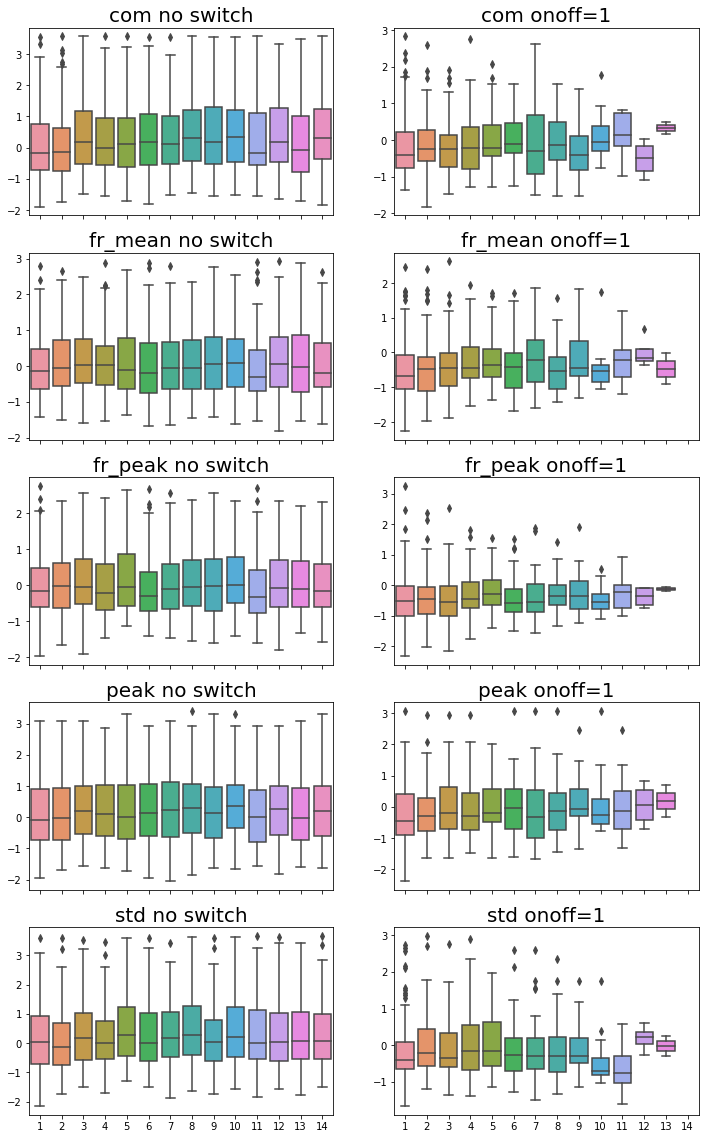

In [146]:
%matplotlib inline
toplot_source = recombined_diff_all_fields_all_param_z#recombined_diff_all_fields_all_param#
par_key_l = toplot_source.index.get_level_values(0).unique()

nplots = len(par_key_l)
fig,axs=plt.subplots(nplots,2,sharex=True,figsize=(2*6,nplots*4))
for n,par_key in enumerate(par_key_l):
    toplot = toplot_source.loc[par_key].loc[fields_ind_d['no_sw']].groupby(level=(0,1)).median()
    sns.boxplot(data=toplot,ax=axs[n,0])
    axs[n,0].set_title(f'{par_key} no switch')

    toplot = toplot_source.loc[par_key].loc[fields_ind_d[onoff]].groupby(level=(0,1)).median()
    sns.boxplot(data=toplot,ax=axs[n,1])
    axs[n,1].set_title(f'{par_key} onoff={onoff}')

In [16]:
recombined_diff_melt = melt_elapsed_trial_diff_mat_sep_fields_all_params(recombined_diff_all_fields_all_param,fields_ind_d,mat_key_l=None)
recombined_diff_melt_z = melt_elapsed_trial_diff_mat_sep_fields_all_params(recombined_diff_all_fields_all_param_z,fields_ind_d,mat_key_l=None)


In [17]:
def display_regression(res):
    '''
    res: from smf.old().fit()
    '''
    display=pd.concat({'params':res.params.round(3),'p':res.pvalues.round(3)},axis=1)
    display['r2'] = res.rsquared_adj.round(5)
    print(display)
    return display

In [21]:
for mat_key in par_key_l:
    model = smf.ols(f'{mat_key}~trial',data=recombined_diff_melt.query('switch_type=="no_sw"'))
    res=model.fit()
    print('\n',mat_key)
    display_regression(res)
#     print(res.summary())


 com
           params    p       r2
Intercept   2.336  0.0  0.00716
trial       0.023  0.0  0.00716

 fr_mean
           params     p       r2
Intercept   2.891  0.00 -0.00013
trial       0.004  0.47 -0.00013

 fr_peak
           params      p       r2
Intercept   5.062  0.000  0.00003
trial       0.010  0.288  0.00003

 peak
           params      p       r2
Intercept   4.909  0.000  0.00278
trial       0.026  0.001  0.00278

 std
           params     p       r2
Intercept   0.758  0.00 -0.00011
trial       0.001  0.45 -0.00011


In [148]:
for mat_key in par_key_l:
    model = smf.ols(f'{mat_key}~trial*C(switch_type)',data=recombined_diff_melt)
    res=model.fit()
    print('\n',mat_key)
    display_regression(res)

#     print(res.summary())


 com
                               params      p       r2
Intercept                       1.011  0.000  0.01575
C(switch_type)[T.no_sw]         0.426  0.001  0.01575
trial                           0.007  0.754  0.01575
trial:C(switch_type)[T.no_sw]   0.004  0.877  0.01575

 fr_mean
                               params      p       r2
Intercept                       1.962  0.000  0.00048
C(switch_type)[T.no_sw]         0.330  0.110  0.00048
trial                           0.019  0.602  0.00048
trial:C(switch_type)[T.no_sw]  -0.023  0.542  0.00048

 fr_peak
                               params      p       r2
Intercept                       2.785  0.000  0.00335
C(switch_type)[T.no_sw]         0.804  0.014  0.00335
trial                           0.050  0.382  0.00335
trial:C(switch_type)[T.no_sw]  -0.049  0.414  0.00335

 peak
                               params      p       r2
Intercept                       2.050  0.000  0.02084
C(switch_type)[T.no_sw]         1.246  0.000  0.0

In [34]:
# Z scored!! No switch
print('z scored, no switch')
for mat_key in par_key_l:
    model = smf.ols(f'{mat_key}~trial',data=recombined_diff_melt_z.query('switch_type=="no_sw"'))
    res=model.fit()
    print('\n',mat_key)
    display_regression(res)
#     print(res.summary())

z scored, no switch

 com
           params    p       r2
Intercept   0.402  0.0  0.01267
trial       0.016  0.0  0.01267

 fr_mean
           params      p       r2
Intercept   0.122  0.000  0.00056
trial       0.003  0.077  0.00056

 fr_peak
           params     p       r2
Intercept   0.183  0.00  0.00097
trial       0.004  0.03  0.00097

 peak
           params    p       r2
Intercept   0.217  0.0  0.01466
trial       0.017  0.0  0.01466

 std
           params      p       r2
Intercept   0.384  0.000  0.00091
trial       0.005  0.035  0.00091


In [149]:
# Z scored!!
print('z scored')
for mat_key in par_key_l:
    model = smf.ols(f'{mat_key}~trial*C(switch_type)',data=recombined_diff_melt_z)
    res=model.fit()
    print('\n',mat_key)
    display_regression(res)

#     print(res.summary())

z scored

 com
                               params      p       r2
Intercept                      -0.143  0.096  0.02424
C(switch_type)[T.no_sw]         0.349  0.000  0.02424
trial                           0.012  0.500  0.02424
trial:C(switch_type)[T.no_sw]   0.004  0.817  0.02424

 fr_mean
                               params      p      r2
Intercept                      -0.447  0.000  0.0394
C(switch_type)[T.no_sw]         0.577  0.000  0.0394
trial                           0.023  0.096  0.0394
trial:C(switch_type)[T.no_sw]  -0.027  0.064  0.0394

 fr_peak
                               params      p      r2
Intercept                      -0.420  0.000  0.0354
C(switch_type)[T.no_sw]         0.487  0.000  0.0354
trial                           0.014  0.297  0.0354
trial:C(switch_type)[T.no_sw]  -0.015  0.280  0.0354

 peak
                               params      p       r2
Intercept                      -0.208  0.005  0.01351
C(switch_type)[T.no_sw]         0.380  0.000  0.01

# pop vec similarity

In [18]:
fr_map_trial_one_tt = fr_map_trial_df_d.loc[0,0].dropna(axis=1)

In [24]:
no_sw_cells = no_sw_fields.get_level_values(0).unique()
with_sw_cells = with_sw_fields.get_level_values(0).unique()

In [29]:
intersection_cells = no_sw_cells.intersection(with_sw_cells)


Int64Index([ 42,  46,  52,  56,  61,  62,  63,  68,  71,  74,  78,  81,  82,
             85,  86,  88,  91,  92,  96, 100, 102, 105, 108, 110, 118, 132,
            134, 138, 139, 166, 179, 252, 253, 260, 261, 263, 265, 266, 270,
            277, 283, 294, 312, 317, 320, 326, 330, 333, 342, 345, 348],
           dtype='int64')

In [254]:
with_sw_fields

MultiIndex([( 42, 0),
            ( 46, 0),
            ( 52, 2),
            ( 54, 1),
            ( 54, 2),
            ( 56, 1),
            ( 60, 0),
            ( 60, 1),
            ( 61, 1),
            ( 62, 0),
            ...
            (352, 0),
            (353, 0),
            (353, 1),
            (354, 0),
            (354, 1),
            (358, 0),
            (358, 1),
            (359, 0),
            (360, 0),
            (361, 0)],
           length=173)

In [253]:
no_sw_cells

Int64Index([ 39,  40,  42,  46,  47,  48,  50,  52,  53,  55,
            ...
            344, 345, 346, 347, 348, 350, 351, 355, 356, 357],
           dtype='int64', length=130)

In [248]:
fr_map_trial_one_tt.loc[no_sw_cells]

0    1    2    3    4    5    6    7    8    9    10   11   12  \
1.0   0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
363.0 95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

           13        14  
1.0   0   0.0  0.036422  
      1   0.0  0.084949  
      2   0.0  0.193046  
      3   0.0  0.384845  
      4   0.0  0.680661  
...       ...       ...  
363.0 95  0.0  0.000000  
      96  0.0  0.000000  
      97  0.0  0.000000  
      98  0.0  0.000000  
      99  0.0  0.000000  

[31800 rows x 15 columns]

# visualize some no switch fields

In [127]:
no_sw_cells = no_sw_fields.get_level_values(0)[~no_sw_fields.get_level_values(0).duplicated()]

In [128]:
fr_map_trial_nosw = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1).loc[no_sw_cells]


In [129]:
Xhat = switch_res['avg']['X'][0.3][task_ind,tt_ind]

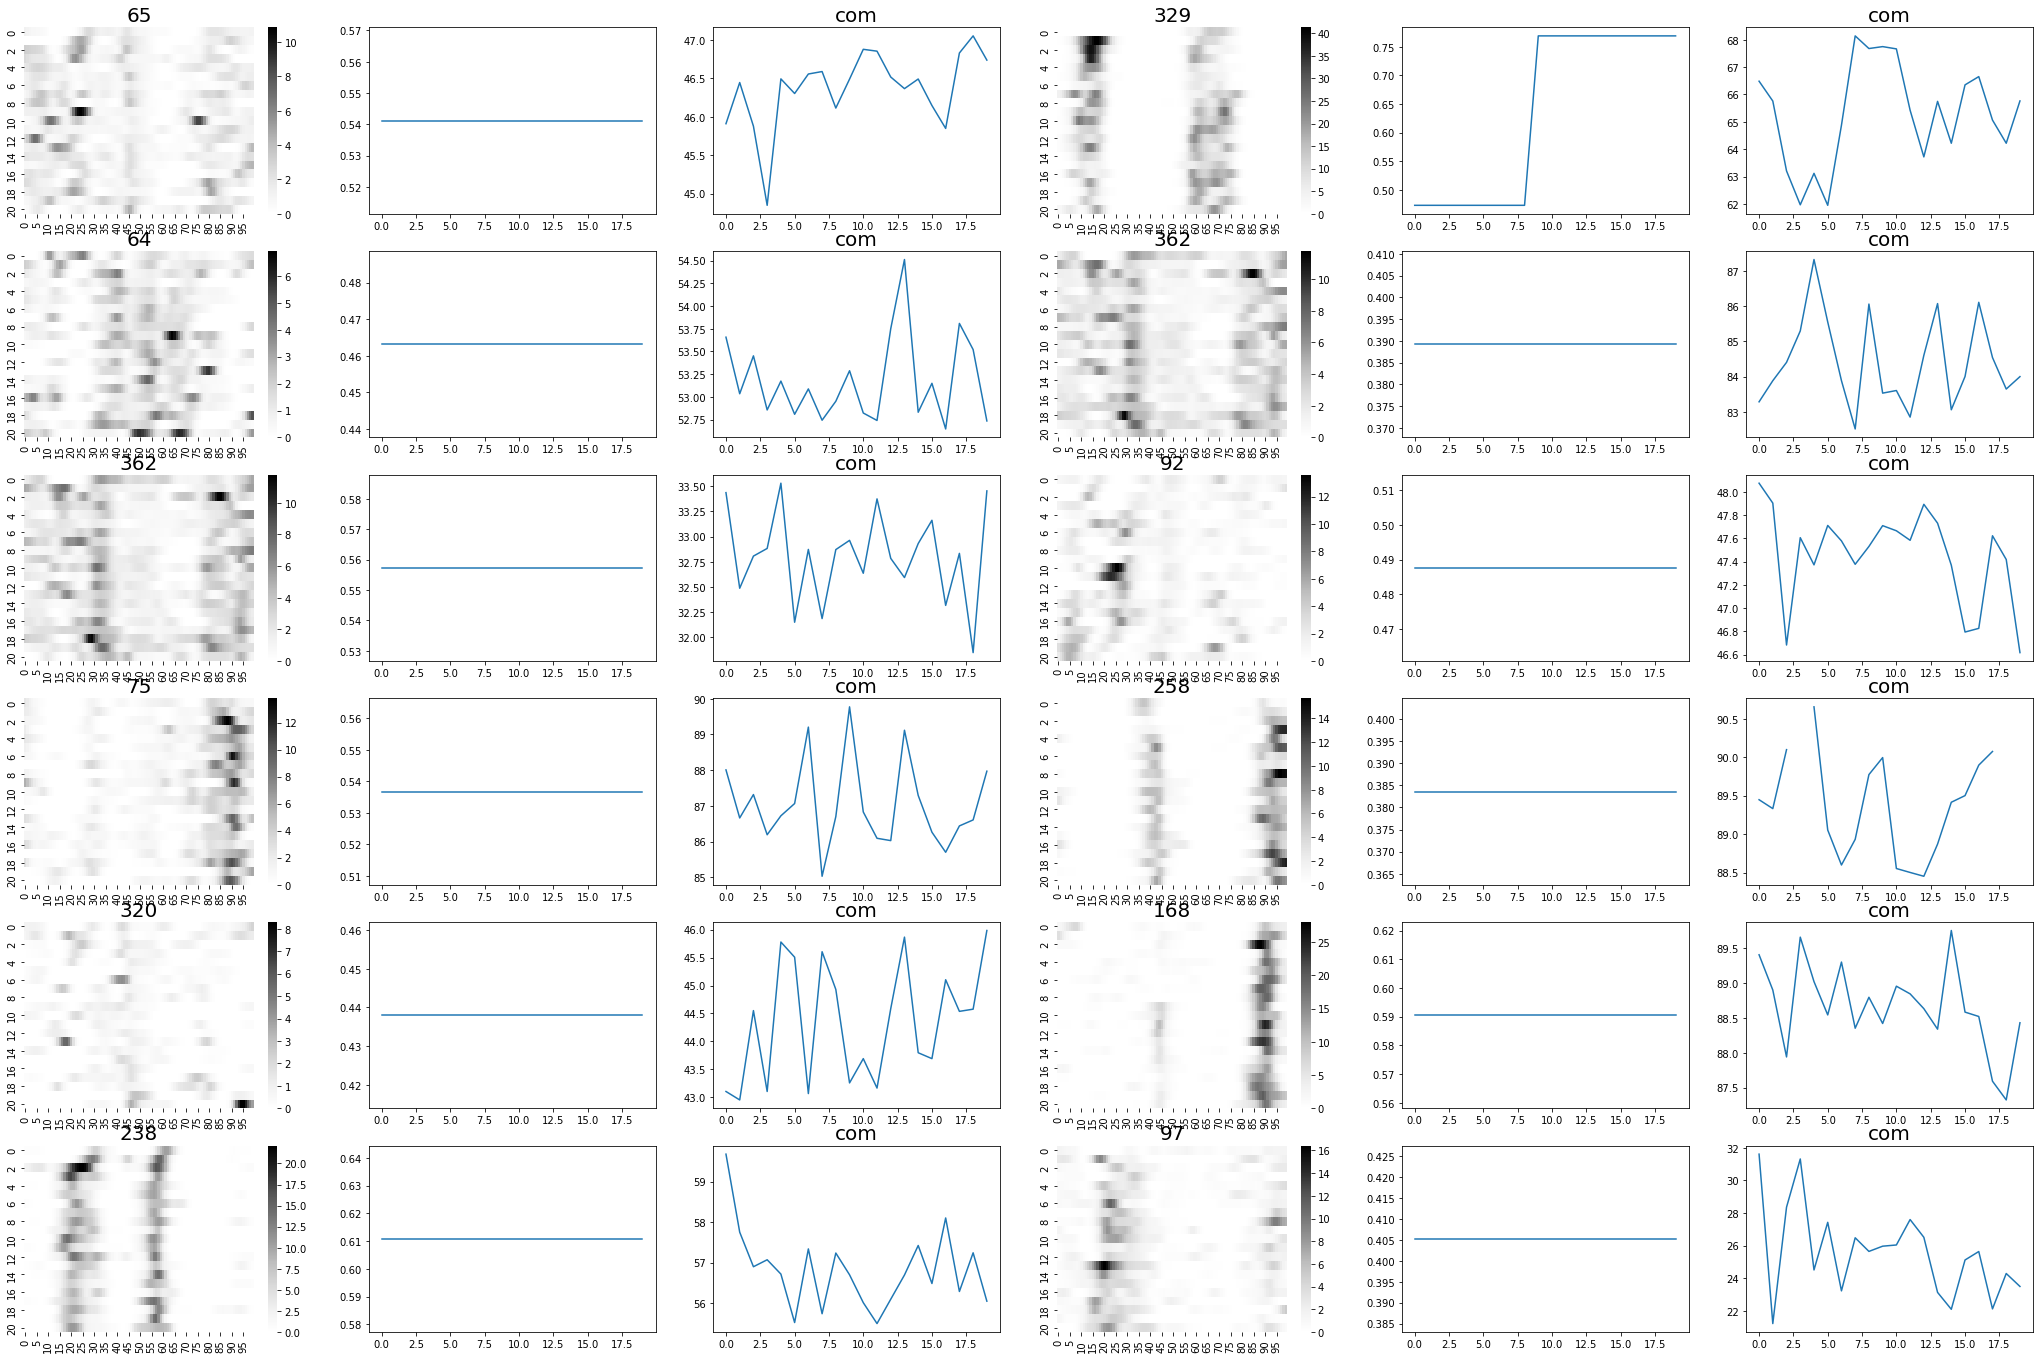

In [134]:
ncells = 12
nsubper = 3
nplots = ncells * nsubper
# cell_inds_sub=np.random.choice(no_sw_cells,nplots)
cell_field_inds_sub=np.random.choice(no_sw_fields,nplots)

fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
for n in range(ncells):
    uid,fid = cell_field_inds_sub[n]
    data = fr_map_trial_nosw.loc[uid].T
    ax=axs.ravel()[n*nsubper]
    sns.heatmap(data=data,ax=ax,cmap='Greys')
    ax.set_title(uid)
    Xhat.loc[uid,fid].T.plot(ax=axs.ravel()[n*nsubper+1])
    
    ax = axs.ravel()[n*nsubper+2]
    pf_res['avg']['params'][task_ind,tt_ind].loc['com'].loc[uid,fid].T.plot(ax=ax)
    ax.set_title('com')
    

In [76]:
switch_res['avg']['X'][0.3][task_ind,tt_ind]

0         1         2         3         4         5         6   \
3   0  0.158324  0.158324  0.158324  0.158324  0.158324  0.158324  0.158324   
27  0  0.690953  0.690953  0.690953  0.690953  0.690953  0.690953  0.690953   
29  0  0.533048  0.533048  0.533048  0.533048  0.533048  0.533048  0.533048   
    1  0.681555  0.681555  0.681555  0.681555  0.681555  0.681555  0.681555   
    2  0.529078  0.529078  0.529078  0.529078  0.529078  0.529078  0.529078   
...         ...       ...       ...       ...       ...       ...       ...   
463 1  0.393942  0.393942  0.393942  0.393942  0.393942  0.393942  0.393942   
465 0  0.090386  0.090386  0.090386  0.090386  0.090386  0.090386  0.090386   
475 0  0.526442  0.526442  0.526442  0.526442  0.526442  0.526442  0.526442   
476 0  1.000000  0.249324  0.249324  0.249324  0.249324  0.249324  0.249324   
480 0  0.392181  0.392181  0.392181  0.392181  0.392181  0.392181  0.392181   

             7         8         9   ...        23        24        25  \
3   0  0.158324  0.158324  0.158324  ...  0.635066  0.635066  0.635066   
27  0  0.690953  0.690953  0.690953  ...  0.690953  0.690953  0.690953   
29  0  0.533048  0.533048  0.533048  ...  0.133318  0.133318  0.133318   
    1  0.681555  0.681555  0.681555  ...  0.681555  0.681555  0.681555   
    2  0.529078  0.529078  0.529078  ...  0.529078  0.529078  0.529078   
...         ...       ...       ...  ...       ...       ...       ...   
463 1  0.393942  0.393942  0.393942  ...  0.176528  0.176528  0.176528   
465 0  0.090386  0.090386  0.090386  ...  0.073844  0.073844  0.073844   
475 0  0.133371  0.133371  0.133371  ...  0.133371  0.133371  0.133371   
476 0  0.249324  0.249324  0.249324  ...  0.006237  0.006237  0.006237   
480 0  0.392181  0.392181  0.392181  ...  0.707686  0.707686  0.707686   

             26        27        28        29        30        31        32  
3   0  0.635066  0.635066  0.635066  0.635066  0.635066  0.635066  0.635066  
27  0  0.690953  0.690953  0.690953  0.690953  0.690953  0.690953  0.690953  
29  0  0.133318  0.133318  0.133318  0.133318  0.133318  0.133318  0.133318  
    1  0.681555  0.681555  0.681555  0.681555  0.681555  0.681555  0.681555  
    2  0.529078  0.529078  0.529078  0.529078  0.529078  0.529078  0.529078  
...         ...       ...       ...       ...       ...       ...       ...  
463 1  0.176528  0.176528  0.176528  0.176528  0.176528  0.176528  0.888005  
465 0  0.073844  0.073844  0.073844  0.073844  0.073844  0.073844  0.073844  
475 0  0.133371  0.133371  0.133371  0.133371  0.133371  0.133371  0.133371  
476 0  0.006237  0.006237  0.006237  0.006237  0.006237  0.006237  0.006237  
480 0  0.707686  0.707686  0.707686  0.707686  0.707686  0.707686  0.707686  

[386 rows x 33 columns]

<AxesSubplot:ylabel='None-None'>

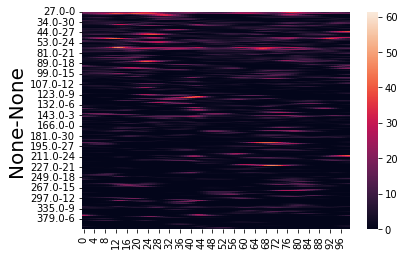

In [59]:
sns.heatmap(data=fr_map_trial_nosw.stack().unstack(level=1))

In [136]:
# recombined_diff_all_param = trialpair_diff_all_params_abs.groupby(level=0).apply(lambda x:realign_to_event(changes_df,x.droplevel(0),onoff=1,k=0))
# recombined_diff_nosw_all_param = trialpair_diff_all_params_abs.groupby(level=0).apply(lambda x:x.droplevel(0).loc[no_sw_ind_to_query])


<AxesSubplot:>

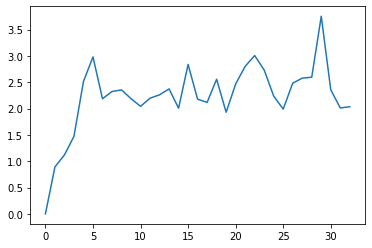

In [63]:
trialpair_diff_all_params.loc['com'].loc[slice(None),slice(None),0].abs().median().plot()

In [45]:
mat = pairwise_trial_difference(pf_param.loc['fr_mean'])

<AxesSubplot:>

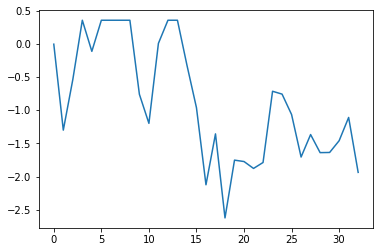

In [50]:
%matplotlib inline
mat.loc[3,0,0].plot()

In [43]:
mat.loc[3,0]

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.000000,-1.298529,-0.533903,0.361854,-0.108133,0.361854,0.361854,0.361854,0.361854,-0.757167,...,-0.711365,-0.754353,-1.062972,-1.705200,-1.365480,-1.638503,-1.636117,-1.458515,-1.106899,-1.936811
1,1.298529,0.000000,0.764626,1.660383,1.190396,1.660383,1.660383,1.660383,1.660383,0.541362,...,0.587164,0.544176,0.235558,-0.406671,-0.066951,-0.339974,-0.337588,-0.159986,0.191631,-0.638282
2,0.533903,-0.764626,0.000000,0.895757,0.425770,0.895757,0.895757,0.895757,0.895757,-0.223264,...,-0.177462,-0.220450,-0.529069,-1.171297,-0.831577,-1.104600,-1.102214,-0.924612,-0.572996,-1.402909
3,-0.361854,-1.660383,-0.895757,0.000000,-0.469987,0.000000,0.000000,0.000000,0.000000,-1.119021,...,-1.073219,-1.116206,-1.424825,-2.067054,-1.727334,-2.000357,-1.997971,-1.820369,-1.468752,-2.298665
4,0.108133,-1.190396,-0.425770,0.469987,0.000000,0.469987,0.469987,0.469987,0.469987,-0.649034,...,-0.603232,-0.646220,-0.954839,-1.597067,-1.257347,-1.530370,-1.527984,-1.350382,-0.998766,-1.828679
5,-0.361854,-1.660383,-0.895757,0.000000,-0.469987,0.000000,0.000000,0.000000,0.000000,-1.119021,...,-1.073219,-1.116206,-1.424825,-2.067054,-1.727334,-2.000357,-1.997971,-1.820369,-1.468752,-2.298665
6,-0.361854,-1.660383,-0.895757,0.000000,-0.469987,0.000000,0.000000,0.000000,0.000000,-1.119021,...,-1.073219,-1.116206,-1.424825,-2.067054,-1.727334,-2.000357,-1.997971,-1.820369,-1.468752,-2.298665
7,-0.361854,-1.660383,-0.895757,0.000000,-0.469987,0.000000,0.000000,0.000000,0.000000,-1.119021,...,-1.073219,-1.116206,-1.424825,-2.067054,-1.727334,-2.000357,-1.997971,-1.820369,-1.468752,-2.298665
8,-0.361854,-1.660383,-0.895757,0.000000,-0.469987,0.000000,0.000000,0.000000,0.000000,-1.119021,...,-1.073219,-1.116206,-1.424825,-2.067054,-1.727334,-2.000357,-1.997971,-1.820369,-1.468752,-2.298665
9,0.757167,-0.541362,0.223264,1.119021,0.649034,1.119021,1.119021,1.119021,1.119021,0.000000,...,0.045802,0.002814,-0.305805,-0.948033,-0.608313,-0.881336,-0.878950,-0.701348,-0.349732,-1.179644


In [13]:
mat

3    0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
27   0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
29   0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
     1    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
     2    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
                                ...                        
463  1    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
465  0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
475  0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
476  0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
480  0    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
Length: 386, dtype: object

In [9]:
pf_param.

0          1          2          3          4   \
fr_mean 3   0   0.361854   1.660383   0.895757   0.000000   0.469987   
        27  0  14.497671  13.804467  23.114017  20.660537  24.060318   
        29  0   5.357048   8.640619  11.218283   9.660357   6.298226   
            1   9.346967   7.827861  16.289806  15.501734   6.856234   
            2   3.397325  16.521741  12.426897   7.661892   9.691956   
...                  ...        ...        ...        ...        ...   
std     463 1   2.160638   2.005217   2.143361   1.892196   2.105187   
        465 0   0.596658   2.923143        NaN   2.424171        NaN   
        475 0   3.162053   2.819765   3.167099   2.886244   2.891080   
        476 0   2.029287   2.425701   2.438282   2.793227   2.644458   
        480 0   3.035396   3.010349   3.380375   4.669752   3.790325   

                      5          6          7          8          9   ...  \
fr_mean 3   0   0.000000   0.000000   0.000000   0.000000   1.119021  ...   
        27  0  18.031251  23.890767  18.535940  16.360925  17.245221  ...   
        29  0  16.213038  13.361689  10.567988  11.872521   9.737256  ...   
            1  12.040284  10.954014  11.643840  12.378693  13.070888  ...   
            2   6.869698   6.792663   3.437770   5.679589  12.695125  ...   
...                  ...        ...        ...        ...        ...  ...   
std     463 1   1.879038   1.920407   1.376514   2.036755   2.412102  ...   
        465 0   2.299744   2.725661        NaN   4.594505   2.573303  ...   
        475 0   2.767675   2.772430   2.718800   3.009274   3.048366  ...   
        476 0   2.360428   1.882534   2.522186   2.637506   2.858958  ...   
        480 0   3.015795   3.643526   3.476285   3.556263   4.469704  ...   

                      23         24         25         26         27  \
fr_mean 3   0   1.073219   1.116206   1.424825   2.067054   1.727334   
        27  0  18.785730  26.555358  22.520142  27.910965  17.187522   
        29  0   7.317475   0.092530   3.476891   1.884900   6.018258   
            1  17.828346  17.131333  19.303846  16.753613  16.884102   
            2  14.163162  11.938834   9.940098  15.245129  11.359280   
...                  ...        ...        ...        ...        ...   
std     463 1   1.618533   2.002209   2.042708   2.046559   2.250909   
        465 0   2.469821        NaN   2.363817   1.902023   2.441664   
        475 0   2.727850   2.766335   2.761957   2.818102   2.702356   
        476 0        NaN        NaN        NaN        NaN        NaN   
        480 0   3.328041   4.009034   3.788421   3.941654   3.657306   

                      28         29         30         31         32  
fr_mean 3   0   2.000357   1.997971   1.820369   1.468752   2.298665  
        27  0  21.923872  31.692889  19.233423  23.450917  19.769685  
        29  0   1.828838   0.382512   6.139012   0.095607   0.458614  
            1  11.851607  15.581193  11.995440  13.127372  14.444362  
            2   6.171581   6.378478   7.828683   4.355117   4.434275  
...                  ...        ...        ...        ...        ...  
std     463 1   1.908929   2.089821        NaN   2.039449   2.091486  
        465 0        NaN   2.401132        NaN   5.751352        NaN  
        475 0   3.033483   2.126476   2.929911   3.121934   3.176648  
        476 0        NaN        NaN        NaN        NaN        NaN  
        480 0   3.068466   3.371639   3.159068   4.487240   4.790587  

[1930 rows x 33 columns]